In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import random 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

### Load data

In [155]:
df = pd.read_csv("Data/data_daily/dataset_daily.csv")
df.head(2)

,Date,Open_USD_CHF,Open_CHF_EUR,Open_CHF_GBP,Open_CHF_JPY,Open_CHF_CAD,Open_BondCH1m,Open_BondCH2y,Open_BondCH10y,Open_SMI,Open_USD_JPY,Open_USD_EUR,Open_USD_GBP,Open_USD_CAD,Open_BondUS1m,Open_BondUS2y,Open_BondUS10y,Open_SP500
0,2001-12-27,1.6886,0.6723,0.4071,77.46,0.9477,1.68,2.011,3.460,6392.1,130.82,1.1356,0.6876,1.6010,1.751,3.307,5.072,1149.4
1,2001-12-28,1.6776,0.6745,0.4106,78.48,0.9520,1.68,2.059,3.474,6430.6,131.68,1.1319,0.6887,1.5981,1.720,3.169,5.113,1157.1


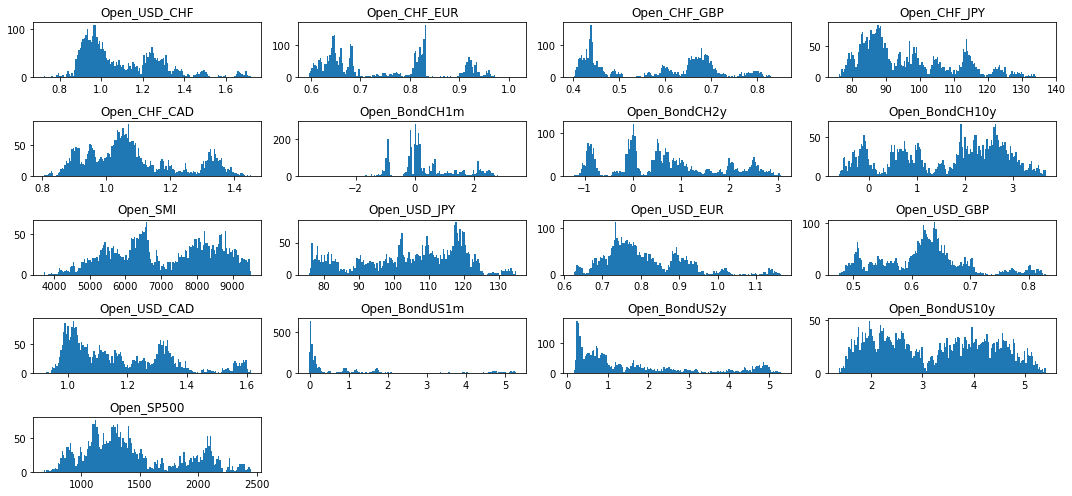

In [156]:
data = []
for i in df.columns[1:]:
    data.append(df[i])

fig = plt.figure(figsize=(15, 7))

name  = df.columns[1:]

for i in range(len(data)):   
    plt.subplot(5, 4,1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

60
20
26
Shape:             
X train     (2708, 7, 17), y train     (2708, 3, 17)            
X train val (301, 7, 17) , y train val (301, 3, 17)             
X test      (532, 7, 17) , y test      (532, 3, 17)


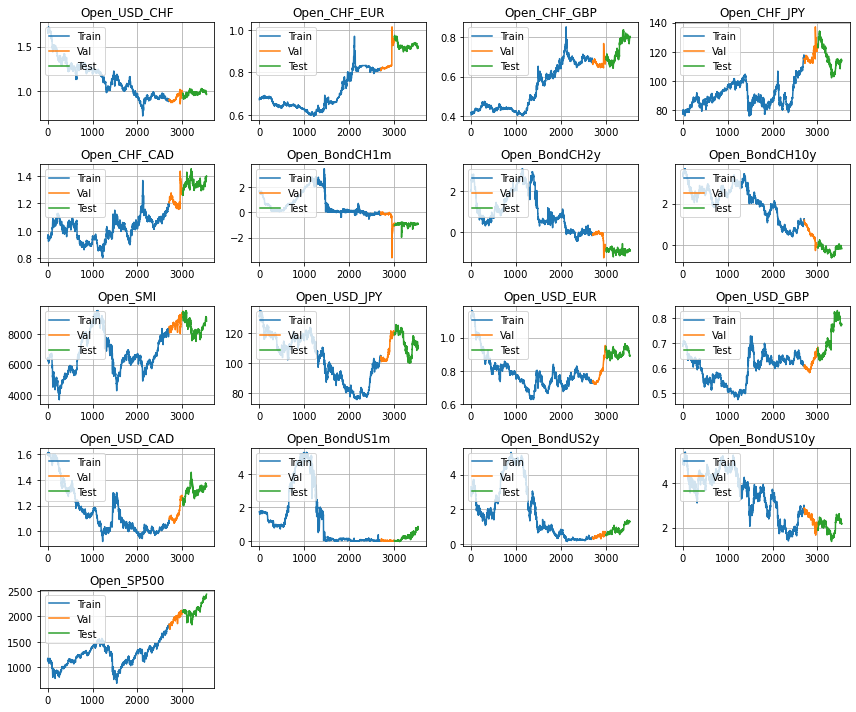

In [219]:
device = 'cpu'
LOOKBACK = 7

train_x, val_x, test_x, train_y, val_y, test_y, norm, price= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=True,
  span_trend_=1,
  span_back_trend_= 2,
  tresh=0.003,
  norm_=True,

  fraction_val_=0.1,
  fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(5, 4,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

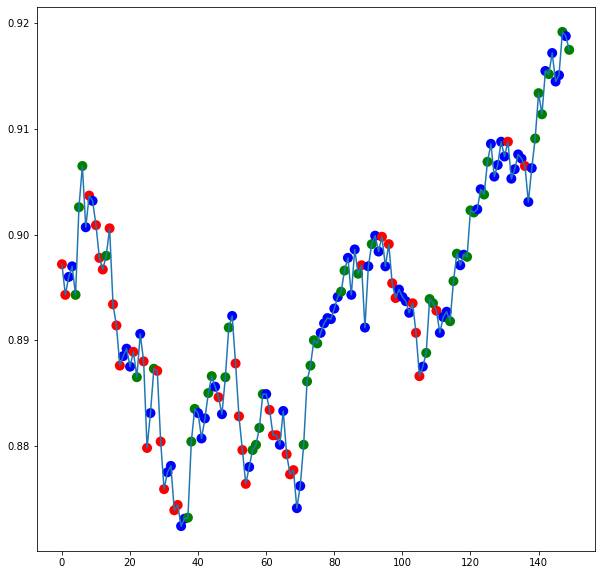

In [220]:
end = 150#300 l2
colors = {0:'red', 1:'blue', 2:'green'}
plt.figure(figsize=(10,10))

real = np.argmax(val_y[:,:,0], axis=1)
plt.scatter(np.arange(end), price[l1:l1+end], c=pd.Series(real[:end]).map(colors).values, s=100, lw=0)
plt.plot(np.arange(end), price[l1:l1+end])


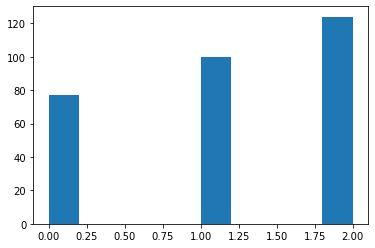

In [251]:
plt.hist(np.argmax(val_y[:,:,0], axis=1))
plt.show()

In [227]:
train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y[np.isnan(train_y)] , val_y[np.isnan(val_y)], test_y[np.isnan(test_y)] 

(array([], dtype=float64), array([], dtype=float64), array([], dtype=float64))

# Trend Prediction

In [246]:
buff = np.argmax(train_y[:, :, 0], axis=1)

'''
positive_weight = torch.tensor(
        len(buff[buff == 0.0]) / len(buff[buff == 1.0])
    ).float().to(device)

buff = test_y[:, 0]
buff.sum()/len(buff)

'''
weight = torch.tensor([len(buff[buff == 0]), len(buff[buff == 1]), len(buff[buff == 2])]).float().to(device)



### GRU 1-feature [TODO]

In [38]:
model_gru_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_1.to(device)
model_gru_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 50/50 [00:03<00:00, 15.01it/s]


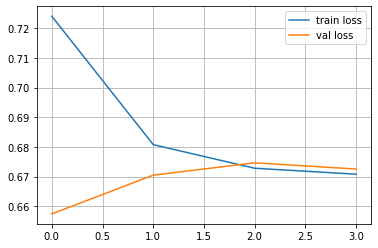

In [39]:
lr= 0.001
num_epochs= 50

train_loss, val_loss = pl.train(
    model=model_gru_1,
    train_x_ = train_x[:,:,0].reshape(-1, LOOKBACK, 1),
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x[:,:,0].reshape(-1, LOOKBACK, 1),
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [41]:
_, _, ACC_gru_1 = pl.evaluate_trend(model_gru_1, val_x[:,:,0].reshape(-1, LOOKBACK,1), val_y[:, 0], device="cpu", verbose=1)


ACC:  0.55250
nb 0 = 295; nb 1 = 105


### GRU 17-feature

In [254]:
model_gru_17 = ml.GRU_base(
        hidden_size=128,
        num_layers=3,
        input_size=17,
        out_features_lin=128,
        out_features_end=3,
        dropout=0.05,
        device=device)
model_gru_17.to(device)
model_gru_17

GRU_base(
  (gru): GRU(17, 128, num_layers=3, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=128, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

100%|██████████| 20/20 [00:33<00:00,  1.65s/it]


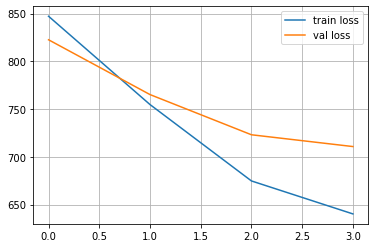

In [255]:
lr= 0.0001
num_epochs= 20

train_loss, val_loss = pl.train(
    model=model_gru_17,
    train_x_ = train_x,
    train_y_ = train_y[:,:,0].reshape(-1,3),
    val_x_ = val_x,
    val_y_= val_y[:,:,0].reshape(-1,3),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.CrossEntropyLoss(weight=weight),#(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [249]:
out, tar, ACC_gru_9 = pl.evaluate_trend(model_gru_17, val_x, val_y[:, :,0], device="cpu", verbose=1)


ACC:  0.57807
nb 0 = 124; nb 1 = 7


<AxesSubplot:>

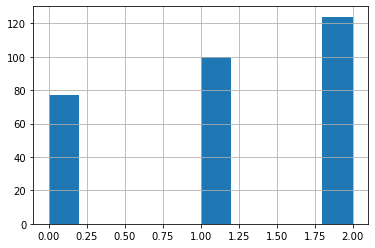

In [250]:
pd.Series(tar).hist()

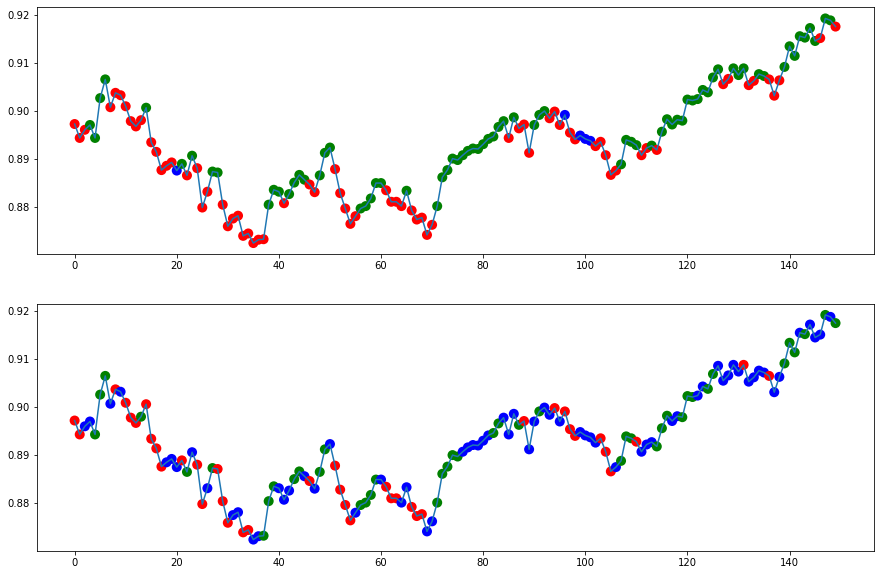

In [253]:
end = 150#300 l2
colors = {0:'red', 1:'blue', 2:'green'}


plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.scatter(np.arange(end), price[l1:l1+end], c=pd.Series(out[:end]).map(colors).values, s=100, lw=0)
plt.plot(np.arange(end), price[l1:l1+end])
plt.subplot(2,1,2)

plt.scatter(np.arange(end), price[l1:l1+end], c=pd.Series(tar[:end]).map(colors).values, s=100, lw=0)
plt.plot(np.arange(end), price[l1:l1+end])





### GRU + Auto-Encoder 1-feature 

In [227]:
model_autoenc_1 = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1.load_state_dict(torch.load('Helper/model/model_autoenc_1.pth'))
model_autoenc_1.to(device)
model_autoenc_1

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

In [240]:
model_gru_autoenc_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_1.to(device)
model_gru_autoenc_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 40/40 [00:02<00:00, 18.15it/s]


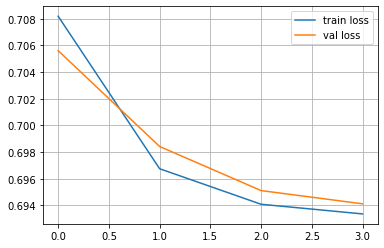

In [241]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp1.to(device).float())
train_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp2.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

lr= 0.001
num_epochs= 40

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [242]:
inp3 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp3.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

_, _, ACC_gru_autoenc_1 = pl.evaluate_trend(model_gru_autoenc_1, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.53525
nb 0 = 166; nb 1 = 217


### Dense + latent space Auto-Encoder 1-feature 

In [279]:
model_dense_autoenc_1 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=3,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_1.to(device)
model_dense_autoenc_1

Dense(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

100%|██████████| 25/25 [00:00<00:00, 32.25it/s]


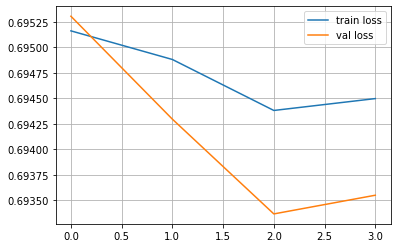

In [284]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

lr= 0.001
num_epochs= 25 

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [375]:
inp3 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out,latent = model_autoenc_1(inp3.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1,3)

_, _, ACC_dense_autoenc_1 = pl.evaluate_trend(model_dense_autoenc_1, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.53786
nb 0 = 173; nb 1 = 210


### GRU + Auto-Encoder 5-feature 

In [397]:
model_autoenc_5 = ml.auto_encoder(input_size=5,
    nb_channel_conv=15)
model_autoenc_5.load_state_dict(torch.load('Helper/model/model_autoenc_5.pth'))
model_autoenc_5.to(device)
model_autoenc_5

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(5, 15, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(15, 15, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(15, 5, kernel_size=(3,), stride=(1,))
)

In [398]:
model_gru_autoenc_5 = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size=5,
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_5.to(device)
model_gru_autoenc_5

GRU_base(
  (gru): GRU(5, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 17/17 [00:10<00:00,  1.57it/s]


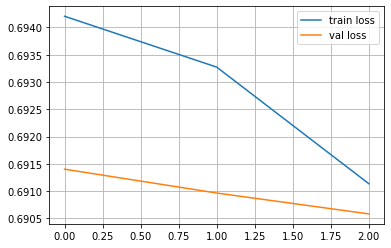

In [400]:
model_autoenc_5.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out = model_autoenc_5(inp1.to(device).float())
train_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_autoenc_5(inp2.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

lr= 0.0001
num_epochs= 17

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_5,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/3)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [401]:
inp3 = torch.from_numpy(np.swapaxes(val_x,1,2))
out = model_autoenc_5(inp3.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)


_, _, ACC_gru_autoenc_5 = pl.evaluate_trend(model_gru_autoenc_5, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.52219
nb 0 = 173; nb 1 = 210


### Dense + latent space Auto-Encoder 5-feature 

In [361]:
model_dense_autoenc_5 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=15,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_5.to(device)
model_dense_autoenc_5

Dense(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

100%|██████████| 15/15 [00:00<00:00, 25.53it/s]


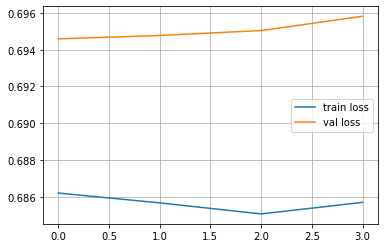

In [368]:
model_autoenc_5.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out, latent = model_autoenc_5(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 15)

inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_5(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 15)

lr= 0.001
num_epochs= 15

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_5,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [373]:
inp3 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_5(inp3.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1,15)

_, _, ACC_dense_autoenc_5 = pl.evaluate_trend(model_dense_autoenc_5, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.48042
nb 0 = 153; nb 1 = 230


### Result 

In [377]:
print(f"ACC GRU 1-feature:                             { ACC_gru_1: 0.08f}")
print(f"ACC GRU 5-features:                            { ACC_gru_5: 0.08f}")
print(f"ACC GRU Auto-Encoder 1-feature:                { ACC_gru_autoenc_1: 0.08f}")
print(f"ACC Dense latent space Auto-Encoder 1-feature: { ACC_dense_autoenc_1: 0.08f}")
print(f"ACC GRU Auto-Encoder 5-feature:                { ACC_gru_autoenc_5: 0.08f}")
print(f"ACC Dense latent space Auto-Encoder 5-feature: { ACC_dense_autoenc_5: 0.08f}")


ACC GRU 1-feature:                              0.52219321
ACC GRU 5-features:                             0.54046997
ACC GRU Auto-Encoder 1-feature:                 0.53524804
ACC Dense latent space Auto-Encoder 1-feature:  0.53785901
ACC GRU Auto-Encoder 5-feature:                 0.54569191
ACC Dense latent space Auto-Encoder 5-feature:  0.48041775
